
### Submitted By: Capstone Group 1 - AIML MAY Group - 3
### Project: AIML Online Capstone - Pneumonia Detection Challenge

#### OBJECTIVE
To build a pneumonia detection system, to locate the position of inflammation in an image.
#### CONTEXT
Tissues with sparse material, such as lungs which are full of air, do not absorb the X-rays and appear black in the image. Dense tissues such as bones absorb X-rays and appear white in the image.

While we are theoretically detecting “lung opacities”, there are lung opacities that are not pneumonia related.

In the data, some of these are labeled “Not Normal No Lung Opacity”. This extra third class indicates that while pneumonia was determined not to be present, there was nonetheless some type of abnormality on the image and oftentimes this finding may mimic the appearance of true pneumonia.
#### DATA DESCRIPTION
Dicom original images: - Medical images are stored in a special format called DICOM files (\*.dcm). They contain a combination of header metadata as well as underlying raw image arrays for pixel data.

### Step 1 - Import the dataset.

Let us imports all required packages before importing dataset

In [1]:
# Adding imports required for data cleansing and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline 

# Adding imports for misc and data prep
import os
import cv2
import pydicom #For displaying dcm images

# to ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# %tensorflow_version 2.x
import tensorflow
tensorflow.__version__

'2.7.0'

In [3]:
# Initialize the random number generator
import random

np.random.seed(1)
random.seed(1)
tensorflow.random.set_seed(1)

from sklearn.model_selection import train_test_split

# NN Core imports
from tensorflow import keras
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, Conv2D, Reshape, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D, Dropout, Dense, Flatten, BatchNormalization, MaxPool2D
from tensorflow.keras.utils import to_categorical

Importing the data

In [4]:
# Lets have a look at the dir structure
import os
for dirname, _, _ in os.walk('../input'):
    print(dirname)

../input
../input\rsna-pneumonia-detection-challenge
../input\rsna-pneumonia-detection-challenge\stage_2_test_images
../input\rsna-pneumonia-detection-challenge\stage_2_train_images


Define input path parameters

In [5]:
input_path = "../input/rsna-pneumonia-detection-challenge/"

train_img_path = input_path + 'stage_2_train_images/'
test_img_path = input_path + 'stage_2_test_images/'

# Contains information on the bounding box for each patient id
bounding_box = input_path + 'stage_2_train_labels.csv' 

# Contains detailed class saying whether data refers to Normal, Pneumonia or any other ailments
detailed_class_info = input_path + 'stage_2_detailed_class_info.csv'

# Contains the target data for which we need to train the images
sample_submission = input_path + 'stage_2_sample_submission.csv'

Read the label info data

In [6]:
bounding_box_df = pd.read_csv(bounding_box)
detailed_class_info_df = pd.read_csv(detailed_class_info)
sample_submission_df = pd.read_csv(sample_submission)

For each of the dataframe that is loaded, we are going to perform following,
- Check the shape of dataframe
- Sample content of dataframe
- Dataframe info check
- Duplicate check
- Write consolidated observations on each dataframe

#### Step 1.1 - Working with bounding_box dataframes

Shape of dataframe

In [7]:
print ("Shape of bounding_box dataframe is", bounding_box_df.shape)

Shape of bounding_box dataframe is (30227, 6)


Sample Content:

In [8]:
bounding_box_df.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


Dataframe info:

In [9]:
bounding_box_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


- Data looks to be clean. No null values in any columns.
- 'patientId' columns is our key column in this data frame.

Duplicate check:

In [10]:
# Check for any duplicates in our key column
bounding_box_df['patientId'].is_unique

False

In [11]:
# Lets check out how many duplicates we have !
bounding_box_df_duplicate = bounding_box_df[bounding_box_df.duplicated(['patientId'])]
bounding_box_df_duplicate.shape

(3543, 6)

So we have around 3543 duplicate records of patientId's out of 30227 samples in the dataframe.

Following inferences can be made...
- So, do we have "30227-3543=26684" training images ? (one training image should be for one patient)
- That means, we should have multiple bounding boxes for one patient id, which makes sense for duplicate rows in bounding_box_df dataframe.

In [12]:
path, dirs, files = next(os.walk(train_img_path))
train_img_count = len(files)
train_img_count

26684

- Okay. So, we have 26684 unique patients and a total of 30227 bounding box data. 
- That confirms our assumption that there are multiple bounding boxes for some of the patient dcm images.

**Consolidated observations on train labels dataframe:**
- There are 30227 rows in this dataframe, which are infact bounding boxes data for various patientId's.
- We have 26684 dcm images for 30227 bounding box data. So, there are multiple bounding boxes in some patientId dcm files.
- Train label dataframe holds data which can be interpreted as,
   - patiendId column, having unique id assigned to each patient.
   - if Target is '1', i.e., if its a Pneumonia patient, 
       - we have bounding box co-ordinates with x, y, width and height
   - if Target is '0', i.e., if its NOT a pneumonia patient, 
       - we don't have bounding box co-ordinates

#### Step 1.2 - Working with detailed class info dataframes

Shape of dataframe

In [13]:
print ("Shape of detailed class info dataframe is", detailed_class_info_df.shape)

Shape of detailed class info dataframe is (30227, 2)


Sample Content:

In [14]:
detailed_class_info_df.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


Dataframe info:

In [15]:
detailed_class_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  30227 non-null  object
 1   class      30227 non-null  object
dtypes: object(2)
memory usage: 472.4+ KB


- Data looks to be clean. No null values in any columns.
- 'patientId' columns is our key column in this data frame. Based on patientId, data in this dataframe relates to data in bounding_box_df (bounding box) dataframe.

Duplicate check:

In [16]:
# Check for any duplicates in our key column
detailed_class_info_df['patientId'].is_unique

False

In [17]:
# Lets check out how many duplicates we have !
detailed_class_info_df_duplicate = detailed_class_info_df[detailed_class_info_df.duplicated(['patientId'])]
detailed_class_info_df_duplicate.shape

(3543, 2)

Good to see that duplicate record count for patientId is 3543 and this exactly matches the duplicate count in bounding_box_df (bounding box) dataframe.

**Consolidated observations on detailed class info dataframes:**
- There are 30227 rows in this dataframe.
- There are 3543 duplicate records in this dataframe. This count exactly matches duplicate count in bounding_box_df (bounding box) dataframe.
- Above datafarme holds additional detailed information about the positive and negative classes (Target column) in the training set
- This data may be used to build more nuanced models, as including this information with training data will improve the FPR rate of our model and thereby our model will be more robust !
- So, let us merge bounding_box_df and detailed_class_info_df dataframes to have one single dataframe of interest.

**(Merge) Working with bounding-box and detailed-class-info dataframes**

Merge bounding_box_df and detailed_class_info_df dataframes

In [18]:
train_data_df = pd.concat([bounding_box_df, detailed_class_info_df['class']], axis = 1)
train_data_df.shape

(30227, 7)

Sample Content:

In [19]:
train_data_df.head()

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity


Now we have one single dataframe having details about bounding-box and detailed-class-info dataframes

#### Step 1.3 - Working with sample submission dataframes (target information dataframe)

Shape of dataframe

In [20]:
print ("Shape of sample_submission_df is", sample_submission_df.shape)

Shape of sample_submission_df is (3000, 2)


Sample Content:

In [21]:
sample_submission_df.head()

,patientId,PredictionString
0,0000a175-0e68-4ca4-b1af-167204a7e0bc,0.5 0 0 100 100
1,0005d3cc-3c3f-40b9-93c3-46231c3eb813,0.5 0 0 100 100
2,000686d7-f4fc-448d-97a0-44fa9c5d3aa6,0.5 0 0 100 100
3,000e3a7d-c0ca-4349-bb26-5af2d8993c3d,0.5 0 0 100 100
4,00100a24-854d-423d-a092-edcf6179e061,0.5 0 0 100 100


Dataframe info:

In [22]:
sample_submission_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   patientId         3000 non-null   object
 1   PredictionString  3000 non-null   object
dtypes: object(2)
memory usage: 47.0+ KB


- Target sample data as well looks clean. No null values in any columns.
- 'patientId' columns is our key column and this should relate to the test images that we have in the dataset.

Duplicate check:

In [23]:
# Check for any duplicates in our key column
sample_submission_df['patientId'].is_unique

True

- We have not got any duplicates in sample-submission dataframe. 
- This tells that we should as well have 3000 sample images in our test image directory.

In [24]:
path, dirs, files = next(os.walk(test_img_path))
test_img_count = len(files)
test_img_count

3000

- Okay. So, our test data set is clean.
- we have 3000 samples in the dataframe and 3000 images in the test image directory, which indicates that we have test images for all records in the test/target dataframe.

**Consolidated observations on train labels dataframe:**
- Target data is clean
   - There are 3000 records in sample-submission dataframe. 
   - 3000 record count in dataframe is exactly matching the number of test images in the dataset.
   - There are no duplicate records in the dataframe.
- sample-submission dataframe contains columns 'PredictionString' that holds the target (expected) bounding boxes for the test input dcm image.
- Sample content of 'PredictionString' columns is as,
  - 0.5 0 0 100 100
  - In the above data each value indicates following,
     - confidence-of-prediction bounding-box-x-coordinate bounding-box-y-coordinate width-of-bounding-box height-of-bounding-box
  - In above example,
     - confidence-of-prediction is 0.5
     - bounding-box-x-coordinate is 0
     - bounding-box-y-coordinate is 0
     - width-of-bounding-box is 100
     - height-of-bounding-box is 100

Note: One test image contains only one bounding boxes as reference. Prediction can have multiple bounding boxes detected.

### Step 2 - Data Visualization

#### Step 2.1 How balanced is our target data ?

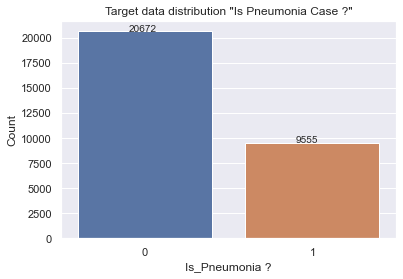

In [25]:
ax = sns.countplot(x="Target", data = bounding_box_df, label="Count");
plt.title('Target data distribution \"Is Pneumonia Case ?\"')
plt.xlabel('Is_Pneumonia ?')
plt.ylabel('Count')
for p in ax.patches:
        ax.annotate('{:d}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()))

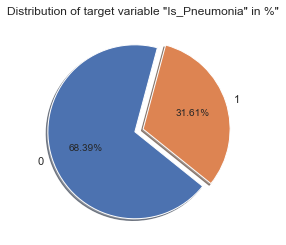

In [26]:
myexplode = [0.1, 0]
plt.pie(bounding_box_df['Target'].value_counts(), 
        labels=bounding_box_df['Target'].unique(), 
        explode=myexplode,
        startangle=75, 
        shadow = True, 
        autopct='%2.2f%%');
plt.title('Distribution of target variable \"Is_Pneumonia\" in %"');

#### Step 2.2 Class distribution in detailed_class_info dataframe

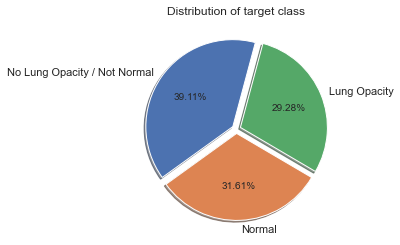

In [27]:
myexplode = [0.05, 0.05, 0.05]
plt.pie(detailed_class_info_df['class'].value_counts(), 
        labels=detailed_class_info_df['class'].unique(), 
        explode=myexplode,
        startangle=75, 
        shadow = True, 
        autopct='%2.2f%%');
plt.title('Distribution of target class');

Note: Normal class % (31.61) in detailed_class_info dataframe, matches with Normal class % (Target 0) in bounding_box dataframe

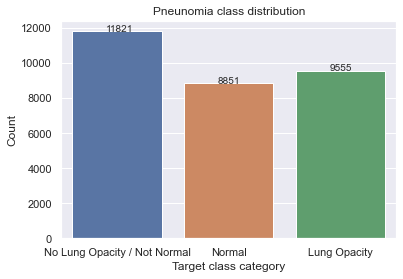

In [28]:
ax = sns.countplot(x='class', data = detailed_class_info_df, label="Count");
plt.title('Pneunomia class distribution')
plt.xlabel('Target class category')
plt.ylabel('Count')
for p in ax.patches:
        ax.annotate('{:d}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()))

We have good distrubution of all three classes in our dataset. Target class is balanced to good extent.

#### Step 2.3 Read and visualize sample dicom images

**-- Let us seggregate positive and negative cases from dataframe --**

In [29]:
# Get the dataframe having only POSITIVE cases
pos_df = train_data_df[(train_data_df['Target'] == 1)][['patientId', 'x', 'y', 'width', 'height', 'class']]
pos_df.head()

,patientId,x,y,width,height,class
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,Lung Opacity
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,Lung Opacity
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,Lung Opacity
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,Lung Opacity
14,00aecb01-a116-45a2-956c-08d2fa55433f,288.0,322.0,94.0,135.0,Lung Opacity


In [30]:
# Get the dataframe having only NEGATIVE cases -> Target class - 'NORMAL'
neg_normal_df = train_data_df[(train_data_df['Target'] == 0) & (train_data_df['class'] == 'Normal')][['patientId', 'x', 'y', 'width', 'height', 'class']]
neg_normal_df.head()

,patientId,x,y,width,height,class
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,Normal
11,009482dc-3db5-48d4-8580-5c89c4f01334,NaN,NaN,NaN,NaN,Normal
12,009eb222-eabc-4150-8121-d5a6d06b8ebf,NaN,NaN,NaN,NaN,Normal
13,00a85be6-6eb0-421d-8acf-ff2dc0007e8a,NaN,NaN,NaN,NaN,Normal
21,00f87de5-5fe0-4921-93ea-914d7e683266,NaN,NaN,NaN,NaN,Normal


In [31]:
# Get the dataframe having only NEGATIVE cases -> Target class - 'NORMAL'
neg_not_normal_df = train_data_df[(train_data_df['Target'] == 0) & (train_data_df['class'] == 'No Lung Opacity / Not Normal')][['patientId', 'x', 'y', 'width', 'height', 'class']]
neg_not_normal_df.head()

,patientId,x,y,width,height,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,No Lung Opacity / Not Normal
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,No Lung Opacity / Not Normal
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,No Lung Opacity / Not Normal


**-- Define a method to take patient data and return the image with bounding box --**

In [32]:
# Method to read dcm image and then apply bounding box over it
def processImage(row, isPos):

    #Extract patientId
    pId = row['patientId']

    #Make the dcm image page for patientId
    dicomFile = train_img_path + pId + '.dcm'
    
    #Get pixel_array of dcm image for display
    img = pydicom.read_file(dicomFile).pixel_array
    
    if (isPos):
        
        #Extract x1, y1 co-ordinates and width, height of bounding box
        x1, y1, width, height = int(row['x']), int(row['y']), int(row['width']), int(row['height'])

        #Apply bounding box co-ordinates and draw lines for the bounding box
        y2 = y1 + height
        x2 = x1 + width
        img[y1:y1 + 6, x1:x2] = 1
        img[y2:y2 + 6, x1:x2] = 1
        img[y1:y2, x1:x1 + 6] = 1
        img[y1:y2, x2:x2 + 6] = 1
    
    return img

**-- Visualize POSITIVE pneumonia cases --**

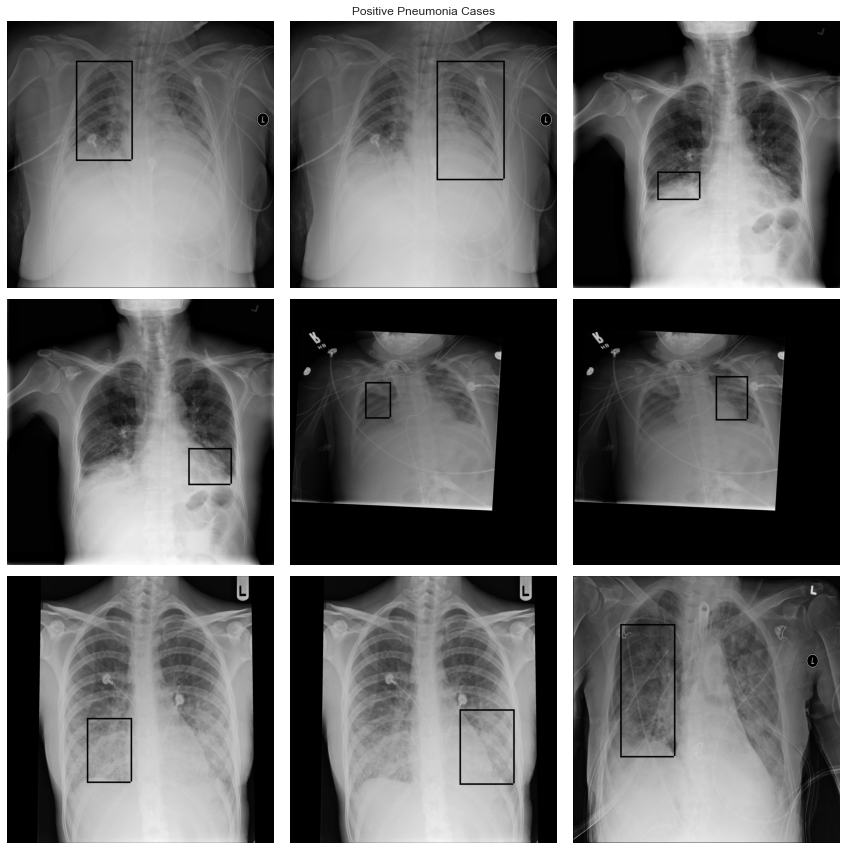

In [33]:
# Draw sample images in 3x3 matrix
plotIndex = 330
plt.figure(figsize=(12,12))
plt.suptitle('Positive Pneumonia Cases')

for index, row in pos_df[0:9].iterrows():
    plotIndex = plotIndex + 1
    plt.subplot(plotIndex)
    plt.axis('off')
    plt.imshow(processImage(row, 1), cmap=plt.cm.gist_gray) 
plt.tight_layout()

**-- Visualize NEGATIVE pneumonia cases - 'No Lung Opacity / Not Normal' class category--**

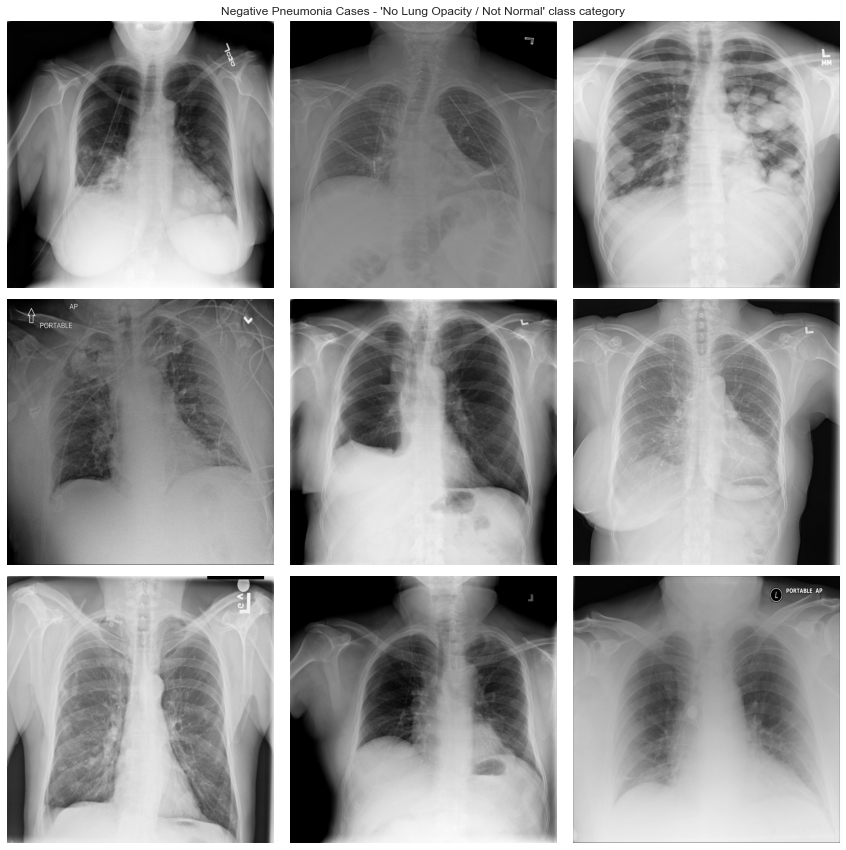

In [34]:
# Draw sample images in 3x3 matrix
plotIndex = 330
plt.figure(figsize=(12,12))
plt.suptitle('Negative Pneumonia Cases - \'No Lung Opacity / Not Normal\' class category')

for index, row in neg_not_normal_df[0:9].iterrows():
    plotIndex = plotIndex + 1
    plt.subplot(plotIndex)
    plt.axis('off')
    plt.imshow(processImage(row, 0), cmap=plt.cm.gist_gray)
plt.tight_layout()

**-- Visualize NEGATIVE pneumonia cases - 'NORMAL' class category--**

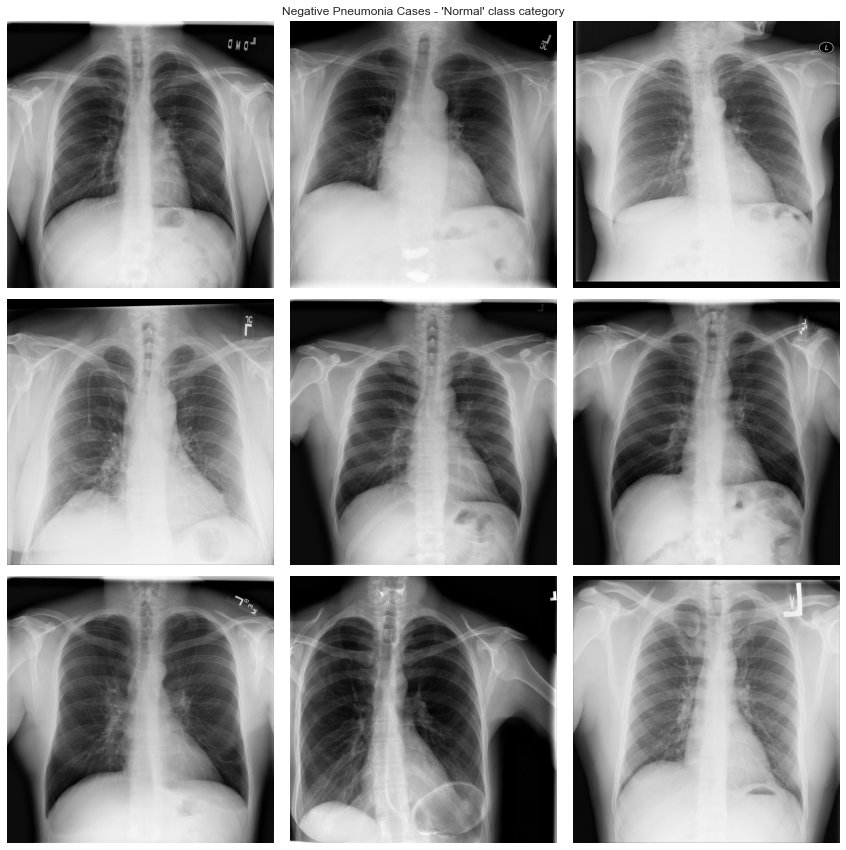

In [35]:
# Draw sample images in 3x3 matrix
plotIndex = 330
plt.figure(figsize=(12,12))
plt.suptitle('Negative Pneumonia Cases - \'Normal\' class category')

for index, row in neg_normal_df[0:9].iterrows():
    plotIndex = plotIndex + 1
    plt.subplot(plotIndex)
    plt.axis('off')
    plt.imshow(processImage(row, 0), cmap=plt.cm.gist_gray)
plt.tight_layout()

### Step 3 - Data Modeling

- We need to load the image data in a format that can be used for model building and model evaluation
- This step will deal with loading the data into a form that is suitable for model building

In [36]:
train_data_df.head()

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity


In [37]:
# Let us stick to 1000 sample images for each class
sampleCount = 2000
train_sample_df = train_data_df.groupby('Target', group_keys=False).apply(lambda x: x.sample(sampleCount))
train_sample_df['Target'].value_counts()

0    2000
1    2000
Name: Target, dtype: int64

In [38]:
train_sample_df.describe()

,x,y,width,height,Target
count,2000.000000,2000.000000,2000.00000,2000.000000,4000.000000
mean,396.956000,361.645000,218.37550,334.255500,0.500000
std,204.479767,147.974657,59.88933,159.442636,0.500063
min,2.000000,3.000000,56.00000,62.000000,0.000000
25%,208.000000,246.000000,177.00000,204.000000,0.000000
50%,340.500000,355.000000,216.00000,308.000000,0.500000
75%,593.250000,473.000000,259.00000,447.000000,1.000000
max,816.000000,816.000000,445.00000,942.000000,1.000000


Data ranges for various fields looks to be in range and valid

In [39]:
train_sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 21247 to 2947
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  4000 non-null   object 
 1   x          2000 non-null   float64
 2   y          2000 non-null   float64
 3   width      2000 non-null   float64
 4   height     2000 non-null   float64
 5   Target     4000 non-null   int64  
 6   class      4000 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 250.0+ KB


- We see that Non-Null count for x, y, width and height is half of total entries.
- It is expected to see, as we have both target classes in train data and we have bounding boxes for only one class category.

Let us observe target split w.r.t., classes that we have in the data

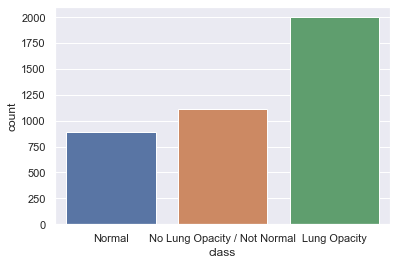

In [40]:
sns.countplot(train_sample_df['class']);

#### Step 3.1 - Data preparation for data modeling

Load images and target classes into arrays

In [41]:
imageSize = 128
imgList = []
targetCatList = []

for index, eachRow in train_sample_df.iterrows():
    
    #Extract patientId
    pId = eachRow['patientId']
    targetCat = eachRow['Target']

    #Make the dcm image page for patientId
    dicomFile = train_img_path + pId + '.dcm'
    
    #Get pixel_array of dcm image for display
    img = pydicom.read_file(dicomFile).pixel_array
    
    #Convert image to 3 channels
    img = np.stack([img] * 3, axis=2)
    
    #Resize image
    img = np.array(img).astype(np.uint8)
    img = cv2.resize(img, (imageSize, imageSize), interpolation = cv2.INTER_LINEAR)
    
    #Add image to target list
    imgList.append(img)
    targetCatList.append(targetCat)

#Convert list to array type (used for modeling)
imgArray = np.array(imgList)
targetCatArray = np.array(targetCatList)

In [42]:
imgArray.shape, targetCatArray.shape

((4000, 128, 128, 3), (4000,))

Encode target class array using a label encoder

In [43]:
from sklearn.preprocessing import LabelEncoder

# Create an object of LabelEncoder
le = LabelEncoder()

# Do fit_transform of target class of training data
targetCatEncoded = le.fit_transform(targetCatArray)

In [44]:
targetCatEncoded

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

Now we have image data and target data encoded.

**- Let's split images/classes as train/test images -**
  - Let us have 70:30 split for train and validation set
  - Further from with in validation sample, lets split 70:30 for validation and test set

In [45]:
X_train, X_test, y_train, y_test = train_test_split(imgArray, targetCatEncoded, test_size=0.4, random_state=1, stratify=targetCatEncoded)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=1, stratify=y_test)

print("Shape of X_train -> ", X_train.shape, ", Shape of y_train -> ", y_train.shape)
print("Shape of X_val -> ", X_val.shape, ", Shape of y_val -> ", y_val.shape)
print("Shape of X_test -> ", X_test.shape, ", Shape of y_test -> ", y_test.shape)

Shape of X_train ->  (2400, 128, 128, 3) , Shape of y_train ->  (2400,)
Shape of X_val ->  (800, 128, 128, 3) , Shape of y_val ->  (800,)
Shape of X_test ->  (800, 128, 128, 3) , Shape of y_test ->  (800,)


In [46]:
y_train = to_categorical(y_train, 3)
y_val = to_categorical(y_val, 3)
y_test = to_categorical(y_test, 3)

In [47]:
y_val

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

#### Step 3.2 - Basic model design

Let us do following steps,
1. Define model structure
2. Define callbacks and fit the model
3. Plot model stats on training and validation data
4. Model evaluation with test data with classification_report

#### Step 3.2.1 - Define model structure

In [48]:
# To get predictable results all the times
np.random.seed(1)
random.seed(1)
tensorflow.random.set_seed(1)

model_structure = Sequential()

# 2D convolution layer
model_structure.add(Conv2D(64, kernel_size=(3,3), input_shape = (imageSize, imageSize, 3), activation='relu'))
model_structure.add(MaxPool2D(pool_size = (2,2))) # Max Pool layer 
model_structure.add(BatchNormalization())

model_structure.add(Conv2D(64, kernel_size=(3,3), strides = (1,1), activation='relu'))
model_structure.add(MaxPool2D(pool_size = (2,2)))
model_structure.add(BatchNormalization())

model_structure.add(Conv2D(128, kernel_size=(3,3), strides = (1,1), activation='relu'))
model_structure.add(MaxPool2D(pool_size = (2,2)))

model_structure.add(Flatten())
model_structure.add(BatchNormalization())
model_structure.add(Dense(128, activation='relu'))
model_structure.add(Dropout(0.2))

model_structure.add(BatchNormalization())
model_structure.add(Dense(32, activation='relu'))
model_structure.add(Dense(3, activation='softmax'))

In [49]:
#To get predictable results all the times
np.random.seed(1)
random.seed(1)
tensorflow.random.set_seed(1)

optimizer = Adam(lr=0.001)
model_structure.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
model_structure.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 63, 63, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                        

#### Step 3.2.2 - Define callbacks and fit the model

In [50]:
#To get predictable results all the times
np.random.seed(1)
random.seed(1)
tensorflow.random.set_seed(1)

# Define Callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5),
    EarlyStopping(monitor='val_loss', patience=5)
]

In [51]:
#To get predictable results all the times
np.random.seed(1)
random.seed(1)
tensorflow.random.set_seed(1)

model_hist = model_structure.fit(
    X_train,
    y_train,
    validation_data = (X_val, y_val),
    epochs=10,
    batch_size=32,
    callbacks=callbacks,
    shuffle=False,
    verbose=1)

Epoch 1/10
75/75 [==============================] - 97s 1s/step - loss: 0.6807 - accuracy: 0.7113 - val_loss: 1.6282 - val_accuracy: 0.5100 - lr: 0.0010
Epoch 2/10
75/75 [==============================] - 91s 1s/step - loss: 0.5343 - accuracy: 0.7487 - val_loss: 0.6444 - val_accuracy: 0.7050 - lr: 0.0010
Epoch 3/10
75/75 [==============================] - 101s 1s/step - loss: 0.4624 - accuracy: 0.7808 - val_loss: 0.5346 - val_accuracy: 0.7513 - lr: 0.0010
Epoch 4/10
75/75 [==============================] - 112s 1s/step - loss: 0.4139 - accuracy: 0.8142 - val_loss: 0.7410 - val_accuracy: 0.6725 - lr: 0.0010
Epoch 5/10
75/75 [==============================] - 88s 1s/step - loss: 0.3700 - accuracy: 0.8363 - val_loss: 0.8487 - val_accuracy: 0.5525 - lr: 0.0010
Epoch 6/10
75/75 [==============================] - 109s 1s/step - loss: 0.3213 - accuracy: 0.8612 - val_loss: 0.6478 - val_accuracy: 0.6762 - lr: 0.0010
Epoch 7/10
75/75 [==============================] - 110s 1s/step - loss: 0.2828

#### Step 3.2.3 - Plot model stats on training and validation data

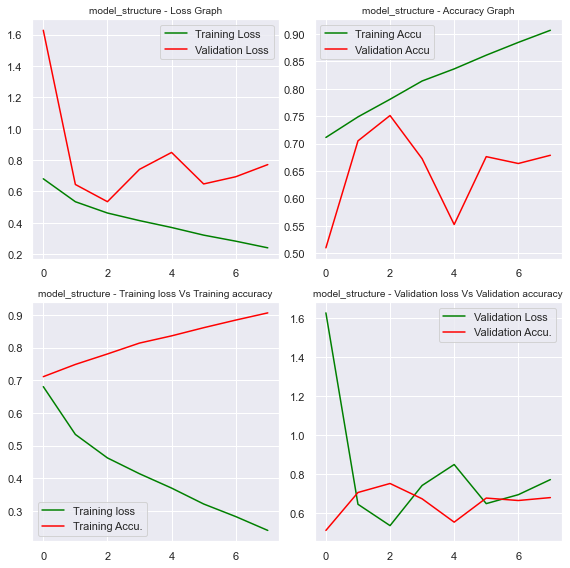

In [52]:
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,8))

ax[0, 0].set_title("model_structure - Loss Graph", fontsize=10)
ax[0, 0].plot(model_hist.history["loss"], color='green')
ax[0, 0].plot(model_hist.history["val_loss"], color='red')
ax[0, 0].legend(["Training Loss", "Validation Loss"], loc='best')

ax[0, 1].set_title("model_structure - Accuracy Graph", fontsize=10)
ax[0, 1].plot(model_hist.history["accuracy"], color='green')
ax[0, 1].plot(model_hist.history["val_accuracy"], color='red')
ax[0, 1].legend(["Training Accu", "Validation Accu"], loc='best')

ax[1, 0].set_title("model_structure - Training loss Vs Training accuracy", fontsize=10)
ax[1, 0].plot(model_hist.history["loss"], color='green')
ax[1, 0].plot(model_hist.history["accuracy"], color='red')
ax[1, 0].legend(["Training loss", "Training Accu."], loc='best')

ax[1, 1].set_title("model_structure - Validation loss Vs Validation accuracy", fontsize=10)
ax[1, 1].plot(model_hist.history["val_loss"], color='green')
ax[1, 1].plot(model_hist.history["val_accuracy"], color='red')
ax[1, 1].legend(["Validation Loss", "Validation Accu."], loc='best')

plt.tight_layout()
plt.show()

#### Step 3.2.4 - Model evaluation with test data with classification_report

In [53]:
modelPerf = model_structure.evaluate(X_test, y_test)

25/25 [==============================] - 7s 287ms/step - loss: 0.7400 - accuracy: 0.6812


In [54]:
print ("Loss observed with test data is ->", round(modelPerf[0],4))
print ("Loss observed with test data is ->", round(modelPerf[1]*100,2), '%')

Loss observed with test data is -> 0.74
Loss observed with test data is -> 68.12 %


In [56]:
from sklearn.metrics import classification_report

# Predict the values from the test dataset
Y_pred = model_structure.predict(X_test)

# Convert predicted and actual classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1)
Y_actl_classes = np.argmax(y_test, axis = 1) 

print (classification_report(Y_actl_classes, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.70      0.64      0.67       400
           1       0.67      0.72      0.69       400

    accuracy                           0.68       800
   macro avg       0.68      0.68      0.68       800
weighted avg       0.68      0.68      0.68       800



#### Step 3.3 - Model design with cross validation (GridSearch or Randomized)

Let us do following steps,
1. Define model structure and define cross validation parameters
2. Perform GridSearch / RandomizedSearch for various cross validation parameters
3. Get the best set of params
4. Redefine the model with best params and build the model
5. Define callbacks and fit the model
6. Plot model stats on training and validation data
7. Model evaluation with test data with classification_report